## Concise Logistic Regression for Image Classification

- Shows a concise implementation of logistic regression for image classification
- Uses PyTorch

In [17]:
# imports
import torch            
import torchvision      # Torchvision 主要用于计算机视觉任务，包括图像处理、数据加载、数据增强、预训练模型等。Torchvision 提供了各种经典的计算机视觉数据集的加载器，以及用于数据预处理和数据增强的工具，可以帮助用户更轻松地进行图像分类、目标检测、图像分割等任务。
import torch.nn as nn   # 导入torch.nn并通过nn来引用  Neural Network:神经网络
# torchvision 主要包含三部分：
# models：      提供深度学习中各种经典网络的网络结构以及预训练好的模型，包括 AlexNet 、VGG 系列、ResNet 系列、Inception 系列等；
# datasets：    提供常用的数据集加载，设计上都是继承 torch.utils.data.Dataset，主要包括 MNIST、CIFAR10/100、ImageNet、COCO等；
# transforms：  提供常用的数据预处理操作，主要包括对 Tensor 以及 PIL Image 对象的操作；
from torchvision import datasets, models, transforms
import os           # python标准库--os模块 Os库提供通用的、基本的操作系统交互功能 常用路径操作、进程管理、环境参数等几类
import numpy as np  # 处理数组和矩阵
import matplotlib.pyplot as plt     # 绘图

%matplotlib inline

# use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")     # torch.device代表将torch.Tensor分配到的设备的对象。判断设备是用显卡还是cpu

In [18]:
# download the data
# !wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
# !unzip hymenoptera_data.zip

In [19]:
# create data loaders   数据加载

data_dir = 'hymenoptera_data'   # 文件名

# custom transformer to flatten the image tensors
class ReshapeTransform:
    def __init__(self, new_size):
        self.new_size = new_size        # newsize: 数据shape

    def __call__(self, img):
        result = torch.reshape(img, self.new_size)      # 进行维度重组
        return result

# transformations used to standardize and normalize the datasets
data_transforms = {                     # 用于标准化和规范化数据集的转换
    # 训练集
    'train': transforms.Compose([       # 变换对象；这些变换操作通常用于数据预处理，例如图像数据的缩放、裁剪、旋转等。使用transforms.Compose可以将多个数据变换组合在一起，以便将它们应用于数据。
        transforms.Resize(224),         # 调整图像大小（将图片短边缩放至x，长宽比保持不变）
        transforms.CenterCrop(224),     # 从中心开始裁剪（CenterCrop(size)：从图片中心开始沿两边裁剪，裁剪后的图片大小为（size*size）） 244 * 244 = 59536
        transforms.ToTensor(),          # 转化为张量
        ReshapeTransform((-1,))         # flattens the data 将多维的数据转化为一维--(-1代表的是n 当有另一维时 -1的值为总/另一维） n=tensor的长度/第一个参数
    ]),
    # (validation)训练集中的测试集--validation的主要作用是来验证是否过拟合、以及用来调节训练参数等(边训练边看到训练的结果，及时判断学习状态)
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        ReshapeTransform((-1,))         # flattens the data
    ]),
}

# load the correspoding folders         加载数据集相关文件夹
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),        # 路径 ../hymenoptera_data/train ; os.path.join()函数用于路径拼接文件路径，可以传入多个路径
                                          data_transforms[x])               # 对图片进行预处理的操作（函数），原始图片作为输入，返回一个转换后的图片
                  for x in ['train', 'val']}                                # 分别遍历训练集和验证集

# load the entire dataset; we are not using minibatches here
# Mini-batching 是一个一次训练数据集的一小部分，而不是整个训练集的技术。它可以使内存较小、不能同时训练整个数据集的电脑也可以训练模型。
train_dataset = torch.utils.data.DataLoader(image_datasets['train'],                    # 创建一个DataLoader对象 传入数据集为上述训练数据集
                                            batch_size=len(image_datasets['train']),    # 每个batch的样本数为训练集样本的大小
                                            shuffle=True)                               # 数据会被随机打乱

test_dataset = torch.utils.data.DataLoader(image_datasets['val'],
                                           batch_size=len(image_datasets['val']),
                                           shuffle=True)

In [20]:
# build the LR model            # 定义逻辑回归模型
class LR(nn.Module):            # logistic regression 继承自 nn.module
    def __init__(self, dim):    
        super(LR, self).__init__()          # 将父类的__init__()放置到自己的__init__()中
        self.linear = nn.Linear(dim, 1)     # 初始化线性变化函数Liner()；输入维度维：dim, 输出维度维:1
        nn.init.zeros_(self.linear.weight)  # 用0填充(全部置为0) weight 张量（权重向量）
        nn.init.zeros_(self.linear.bias)    # 用0填充 bias (偏置值)

    def forward(self, x):           # 前向传播
        x = self.linear(x)          # 执行forword 函数（前向传播）
        x = torch.sigmoid(x)        # 执行 sigmoid 函数（激活函数）
        return x

In [21]:
# predict function          # 预测函数
def predict(yhat, y):
    yhat = yhat.squeeze()   # squeeze() 从数组的形状中删除单维度条目，即把shape中为1的维度去掉
    y = y.unsqueeze(0)      # unsqueeze()函数起升维的作用,参数表示在哪个地方加一个维度。0表示在张量最外层加一个中括号变成第一维。
    y_prediction = torch.zeros(y.size()[1])     # 返回一个形状为y.size()[1],类型为torch.dtype，里面的每一个值都是0的tensor
    for i in range(yhat.shape[0]):      # w.shape[0]返回的是w的行数
        if yhat[i] <= 0.5:              # 如果预测值<= 0.5
            y_prediction[i] = 0         # 分到0类
        else:                           # 如果预测值> 0.5
            y_prediction[i] = 1         # 分到1类
    return 100 - torch.mean(torch.abs(y_prediction - y)) * 100      # 计算准确率 结果*100显示

In [22]:
# model config
dim = train_dataset.dataset[0][0].shape[0]  # 获取特征的维度

lrmodel = LR(dim).to(device)    # 实例化逻辑回归模型并将数据copy到指定设备中
criterion = nn.BCELoss()        # 计算目标值和预测值之间的二进制交叉熵损失函数。   数学公式为Loss = -w * [p * log(q) + (1-p) * log(1-q)]，其中p、q分别为理论标签、实际预测值，w为权重
optimizer = torch.optim.SGD(lrmodel.parameters(), lr=0.0001)        # torch.optim.SGD 随机梯度下降优化算法的类

In [56]:
# training the model
costs = []  # # 损失列表，保存迭代的损失值

for ITER in range(200): # 迭代训练 次数为200
    lrmodel.train()     # 设置模型为训练模式
    x, y = next(iter(train_dataset))            # 取训练数据 x特征数据 y标记
    test_x, test_y = next(iter(test_dataset))   # 取训练集中的测试集 test_x特征数据, test_y标记

    # forward
    yhat = lrmodel.forward(x.to(device))        # 前向传播计算预测值

    cost = criterion(yhat.squeeze(), y.type(torch.FloatTensor))     # 计算目标值和预测值之间的二进制交叉熵损失函数。
    train_pred = predict(yhat, y)               # 预测分类并获得准确率

    # backward
    optimizer.zero_grad()   # 清空上一次的梯度值--optimizer.zero_grad()函数会遍历模型的所有参数，通过p.grad.detach_()方法截断反向传播的梯度流，再通过p.grad.zero_()函数将每个参数的梯度值设为0，即上一次的梯度记录被清空。
    cost.backward()         # 反向传播
    optimizer.step()        # step()函数的作用是执行一次优化步骤，通过梯度下降法来更新参数的值。

    # evaluate  评估
    lrmodel.eval()          # 设置模型为评估模式
    with torch.no_grad():
        yhat_test = lrmodel.forward(test_x.to(device))  # 前向传播计算预测值
        test_pred = predict(yhat_test, test_y)          # 预测分类并获得准确率

    if ITER % 10 == 0:      # 每10轮
        costs.append(cost)  # 保存损失值

    if ITER % 10 == 0:      # 每10轮
        print("Cost after iteration {}: {} | Train Acc: {} | Test Acc: {}".format(ITER,             # 轮次
                                                                                    cost,           # 损失值
                                                                                    train_pred,     # 训练集准确率
                                                                                    test_pred))     # 验证集准确率


Cost after iteration 0: 0.6268343925476074 | Train Acc: 69.26229858398438 | Test Acc: 54.90196228027344
Cost after iteration 10: 0.6159354448318481 | Train Acc: 70.08197021484375 | Test Acc: 56.86274337768555
Cost after iteration 20: 0.6063205003738403 | Train Acc: 72.54098510742188 | Test Acc: 56.20914840698242
Cost after iteration 30: 0.5976808667182922 | Train Acc: 74.18032836914062 | Test Acc: 57.51633834838867
Cost after iteration 40: 0.5898047685623169 | Train Acc: 74.18032836914062 | Test Acc: 57.51633834838867
Cost after iteration 50: 0.5825433731079102 | Train Acc: 74.59016418457031 | Test Acc: 58.1699333190918
Cost after iteration 60: 0.5757877826690674 | Train Acc: 75.0 | Test Acc: 59.47712326049805
Cost after iteration 70: 0.5694577693939209 | Train Acc: 75.40983581542969 | Test Acc: 60.13071823120117
Cost after iteration 80: 0.5634913444519043 | Train Acc: 75.40983581542969 | Test Acc: 60.13071823120117
Cost after iteration 90: 0.5578402280807495 | Train Acc: 75.8196716308

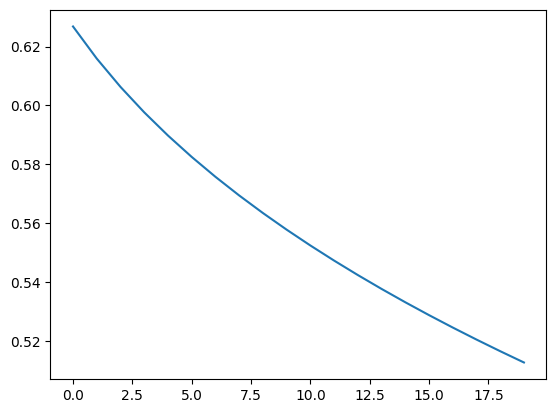

In [58]:
num_costs = []

for item in costs:
    num_costs.append(item.detach().numpy())

plt.plot(num_costs)

### References
- [A Logistic Regression Model from Scratch](https://colab.research.google.com/drive/1iBoJ0kngkOthy7SgVaVQA1aHEROt5mra?usp=sharing)